<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/master/Notebook_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Notebook : Interprétation des modèles de CNN </H1>

L'interprétation des modèles dans les réseaux de neurones convolutifs (CNN) est un aspect essentiel de l'apprentissage profond, car elle nous aide à comprendre et à obtenir des informations sur la manière dont le modèle prend des décisions. Les CNN sont très efficaces pour des tâches telles que la classification d'images, la détection d'objets, et bien d'autres, mais leur fonctionnement interne est souvent considéré comme une "boîte noire". Les techniques d'interprétation visent à éclairer ces boîtes noires et à rendre le processus de prise de décision d'un CNN plus transparent et plus exploitable.  Pour cela nous nous pencherons sur des métriques telles que la **précision**, le **rappel** et la **F1-score**. Nous verrons également la **matrice de confusion**, la **courbe ROC** Ainsi que de méthode d'interprétation de model en CNN : **LIME**, **Grad-cam**, **feature maps** et **SHAP**.

Il existe plusieurs types d'approches pour les méthodes d'interpréter des modèles de type CNN :

1. **Visualisation des feature maps** : Des techniques qui permettent de visualiser les sortie des couche de convolution et de savoir quelles parties d'une image sont les plus responsables de la décision du réseau. Cela aide à comprendre quelles caractéristiques le modèle a apprises. (ex : Feature map)

2. **Méthodes par perturbation** : Les méthodes de perturbation explique les prédictions d'un modèle en ajustant localement un modèle interprétable autour de points de données spécifiques. Elle permet de comprendre comment le modèle se comporte pour des exemples individuels en perturbant les caractéristiques de l'entrée. (ex : LIME)

3. **Méthodes basées sur les gradients** : Des méthodes telles que la cartographie d'activation pondérée par les gradients et les gradients intégrés aident à identifier les régions et les pixels importants en analysant les gradients dans la sortie du réseau par rapport à l'image d'entrée. (ex : Grad-CAM)

L'interprétation des modèles CNN permet non seulement de comprendre leur comportement, mais joue également un rôle essentiel dans le débogage du modèle, l'amélioration de ses performances et la garantie de l'équité et de la transparence dans les systèmes d'IA.

# installation

In [ ]:
!pip install visualkeras
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image
from skimage.segmentation import mark_boundaries
from PIL import Image
from PIL import ImageFont
import tensorflow as tf
import visualkeras
import seaborn as sns
import sklearn
import random

%matplotlib inline

SEED = 123

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/
%mkdir -p My\ Drive/Colab Notebooks/
%cd /content/gdrive/My Drive/Colab Notebooks/
%mkdir -p HAI923/Résultats/
%mkdir -p HAI923/Saved_Model/
%cd HAI923/
%pwd

Mounted at /content/gdrive/
/content/gdrive
mkdir: cannot create directory ‘Notebooks/’: Operation not supported
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks/HAI923


'/content/gdrive/My Drive/Colab Notebooks/HAI923'

In [ ]:
def create_dataset(my_path, my_classes, gray=False, onehot=False) :
  X,y=create_X_y(my_path, my_classes, gray, onehot)
  print("Les classes : ", my_classes)
  print("Nombres de données : ", X.shape[0])
  print ("Résolution des images : ", X[0].shape)
  X=X.astype('float')
  X=X/255.0
  return X,y

def create_training_data(path_data, list_classes, gray=False):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        if gray == False :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2RGB)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        else :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2GRAY)
          equ = cv2.equalizeHist(new_array)
          new_array = np.hstack((new_array,equ))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y(path_data, list_classes, gray=False, onehot=False):
      training_data=create_training_data(path_data, list_classes, gray)
      random.shuffle(training_data)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      if gray == False :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      else :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
      if onehot == False :
        y=np.array(y, dtype=np.float32)
      else :
        y=to_categorical(y, dtype=np.float32) #onehot

      return X,y

# Metrics d'interprétations

Définir le model à charger :

In [ ]:
model = tf.keras.models.load_model('Saved_Model/TLModelArchi_2TrainableVGG16.h5')
IMG_SIZE = model.layers[0].input_shape[0][1]
CHANEL = model.layers[0].input_shape[0][3]
print(f"IMG_SIZE : {IMG_SIZE}, CHANEL : {CHANEL}")
modelName = "TLModelArchi_2TrainableVGG16" # !!! CHANGE NAME HERE !!!
os.makedirs(f'Résultats/{modelName}/', exist_ok=True)

IMG_SIZE : 256, CHANEL : 3


In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'Tiger_negative_class']
Nombres de données :  200
Résolution des images :  (256, 256, 3)
Taille de X_train : 140, Taille de X_val : 30, Taille de X_test : 30


In [ ]:
Y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

f1 = f1_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred, average='macro')
precision = precision_score(Y_test, Y_pred, average='macro')

print(f'Accuracy = {accuracy}')
print(f'Recall = {recall}')
print(f'Precision = {precision}')
print(f'F1 score = {f1}')

1/1 [==============================] - 15s 15s/step
Accuracy = 0.9
Recall = 0.9
Precision = 0.9017857142857143
F1 score = 0.899888765294772


Confusion matrix

1/1 [==============================] - 0s 55ms/step


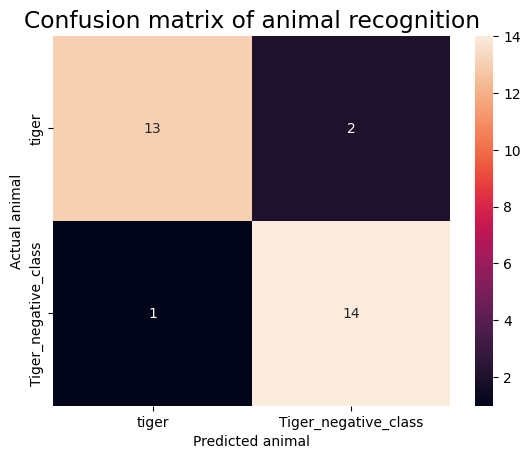

In [ ]:
Y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

cm = tf.math.confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(cm, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(6, 6)})
sns.set(font_scale=1.4)
ax.set_title('Confusion matrix of animal recognition')
ax.set_xlabel('Predicted animal')
ax.set_ylabel('Actual animal')
plt.xticks(rotation=0)
plt.yticks(rotation=90)
ax.xaxis.set_ticklabels(my_classes)
ax.yaxis.set_ticklabels(my_classes)
plt.savefig(f"Résultats/{modelName}/Confusion_matrix.png")
plt.show()
plt.close()

Showing images badly predicted

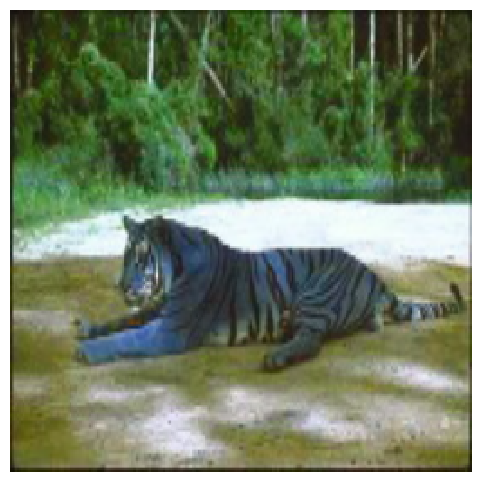

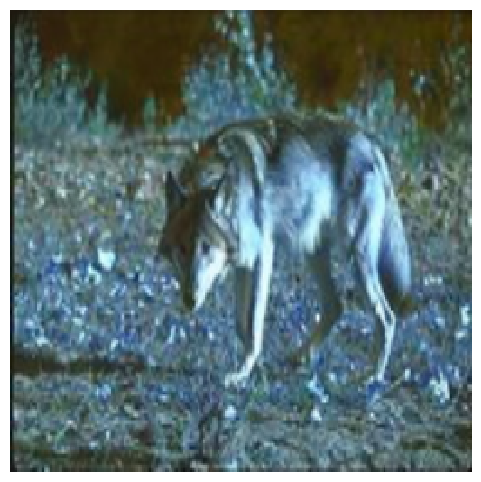

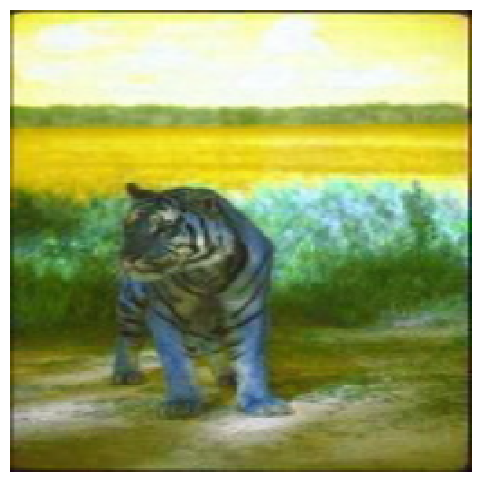

In [ ]:
for i, (Yp, Yt) in enumerate(zip(Y_pred, Y_test)) :
  if Yp != Yt :
    plt.imshow(X_test[i], interpolation='nearest')
    plt.axis('off')
    plt.show()

Roc curve

1/1 [==============================] - 0s 54ms/step


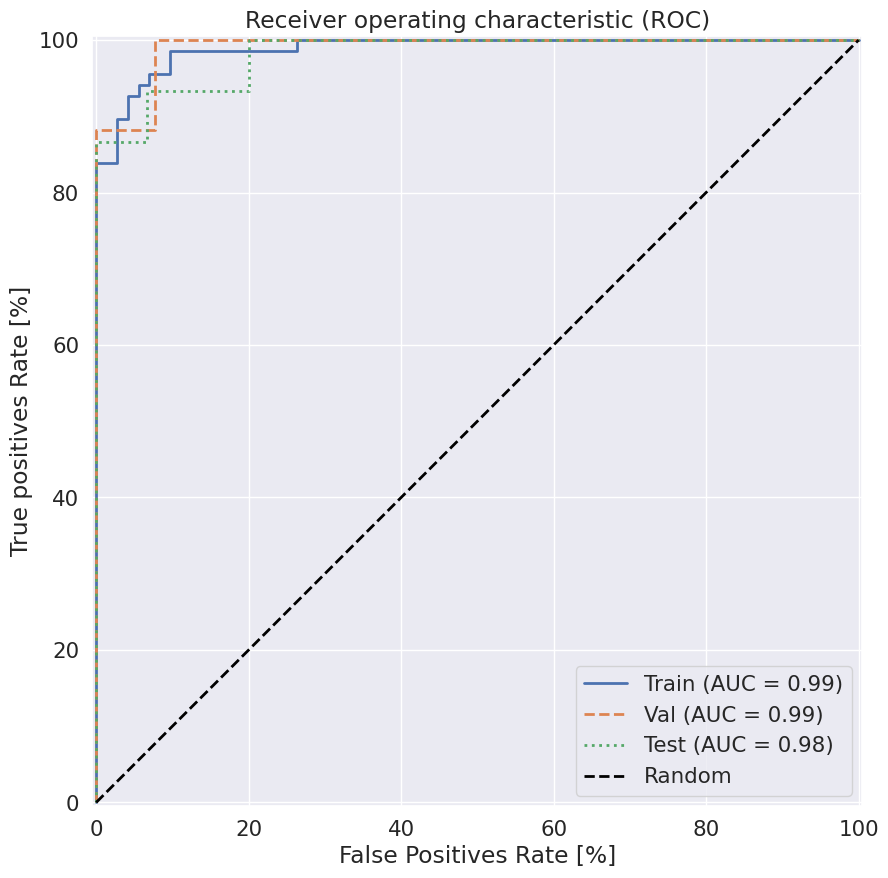

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def ROC_curve(model) :

  train_predictions = model.predict(X_train).ravel()
  val_predictions = model.predict(X_val).ravel()
  test_predictions = model.predict(X_test).ravel()

  """
  print(f"Y_train pred : {train_predictions}")
  print(f"Y_train      : {Y_train}")
  print(f"")

  print(f"Y_val pred   : {val_predictions}")
  print(f"Y_val        : {Y_val}")
  print(f"")

  print(f"Y_test pred  : {test_predictions}")
  print(f"Y_test       : {Y_test}")
  print(f"")
  """

  plot_roc("Train (AUC = %0.2f)", Y_train, train_predictions, color=colors[0])
  plot_roc("Val (AUC = %0.2f)", Y_val, val_predictions, color=colors[1], linestyle='--')
  plot_roc("Test (AUC = %0.2f)", Y_test, test_predictions, color=colors[2], linestyle=':')
  plt.plot([0, 100], [0, 100], label="Random", color='black', linewidth=2, linestyle='--')
  plt.legend(loc='lower right')
  plt.savefig(f"Résultats/{modelName}/Roc_curve.png")
  plt.show()
  plt.close()

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  roc_auc = auc(fp, tp)

  plt.plot(100*fp, 100*tp, label=name % roc_auc, linewidth=2, **kwargs)
  plt.xlabel('False Positives Rate [%]')
  plt.ylabel('True positives Rate [%]')
  plt.title('Receiver operating characteristic (ROC)')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Plot Roc curve
ROC_curve(model)

Plot CNN layer visualisation

In [ ]:
visualkeras.layered_view(model, legend=True) # without custom font
font = ImageFont.truetype("/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

In [ ]:
visualkeras.layered_view(model, legend=True, font=font).save(f"Résultats/{modelName}/model_visualization.png")

# Méthodes d'interprétation

In [ ]:
!pip install lime
!pip install shap

from lime import lime_image
import shap
import lime

## Case creations

In [ ]:
# Initialize lists for TP, FN, FP, and TN
TP_list = []
FN_list = []
FP_list = []
TN_list = []

# Iterate through the predictions and ground truth labels
for i in range(len(Y_pred)):
    if Y_test[i] == 1 and Y_pred[i] == 1:
        TP_list.append(X_test[i])  # True Positives
    elif Y_test[i] == 0 and Y_pred[i] == 1:
        FN_list.append(X_test[i])  # False Positives
    elif Y_test[i] == 1 and Y_pred[i] == 0:
        FP_list.append(X_test[i])  # False Negatives
    elif Y_test[i] == 0 and Y_pred[i] == 0:
        TN_list.append(X_test[i])  # True Negatives

# Create a dictionary to store the results
prediction_dict = {
    'TP': TP_list,
    'FN': FN_list,
    'FP': FP_list,
    'TN': TN_list
}

In [ ]:
os.makedirs(f'Résultats/{modelName}/Lime', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Grad_cam', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Lime', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Shap', exist_ok=True)

## Feature maps

In [ ]:
os.makedirs(f'Résultats/{modelName}/Feature_maps/TP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Feature_maps/FN', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Feature_maps/FP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Feature_maps/TN', exist_ok=True)

# Relicat d'un ancien temps
"""
# Find conv layer index
regex = "\S*conv\S*"
pattern = re.compile(regex)
list_layer_conv = []
number=0
for layer in model.layers :
  m = re.match(pattern, str(layer.name))
  if m :
    list_layer_conv.append(number)
  number+=1
"""

# Iterate through the layers to find convolutional layers
list_layer_conv = []

for i, layer in enumerate(model.layers):
  if isinstance(layer, tf.keras.layers.Conv2D):
    list_layer_conv.append(i)

print(list_layer_conv)

if not list_layer_conv :
  print("Error: No convolutional layers found in the model.")
  sys.exit(1)

total=1
for key, pictures in prediction_dict.items():
  for picture in pictures :
    picture = picture.reshape(-1, IMG_SIZE, IMG_SIZE, CHANEL)

    # Selection des couches correspondant aux convolutions
    outputs = [model.layers[i].output for i in list_layer_conv]
    feature_maps_model = tf.keras.models.Model(inputs=model.inputs , outputs=outputs)
    feature_maps = feature_maps_model.predict(picture)
    feature_map_layer = tf.keras.models.Model(inputs=model.inputs , outputs=model.layers[1].output)
    layer_names = [layer.name for layer in model.layers]
    features = feature_map_layer.predict(picture)

    # Selection des couches correspondant aux convolutions
    for i,fmap in zip(list_layer_conv, feature_maps):
      fig = plt.figure(figsize=(15,10))
      fig.suptitle(layer_names[i] , fontsize=20)
      for i in range(1,features.shape[3]+1) :
        if i > 9 :
          break
        plt.subplot(3,3,i)
        plt.axis('off')
        plt.imshow(fmap[0,:,:,i-1])
        plt.savefig(f'Résultats/{modelName}/Feature_maps/{key}/{total}_{i}.png')
    total+=1

## GRAD-CAM

In [ ]:
os.makedirs(f'Résultats/{modelName}/Grad_cam/TP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Grad_cam/FN', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Grad_cam/FP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Grad_cam/TN', exist_ok=True)

def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[last_conv_layer].output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, i, alpha=0.4):

    img = img * 255
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Return the superimposed image
    return superimposed_img

# Iterate through the layers to find convolutional layers
list_layer_conv = []

for i, layer in enumerate(model.layers):
  if isinstance(layer, tf.keras.layers.Conv2D):
    list_layer_conv.append(i)

if not list_layer_conv :
  print("Error: No convolutional layers found in the model.")
  sys.exit(1)

last_conv_layer = list_layer_conv[-1]

total=1
for key, pictures in prediction_dict.items():
  for picture in pictures :

    # Transform the list into a single ndarray
    picture = np.array(picture)

    # Add an extra dimension to the ndarray
    picture = np.expand_dims(picture, axis=0)

    heatmap = make_gradcam_heatmap(picture, model, last_conv_layer)

    # display heatmap
    image = display_gradcam(picture.reshape(IMG_SIZE,IMG_SIZE,CHANEL), heatmap, i+1)

    plt.axis('off')
    plt.imshow(image)
    plt.savefig(f'Résultats/{modelName}/Grad_cam/{key}/{total}.png')
    plt.show()
    total+=1

## LIME

In [ ]:
os.makedirs(f'Résultats/{modelName}/Lime/TP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Lime/FN', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Lime/FP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Lime/TN', exist_ok=True)

total=1
for key, pictures in prediction_dict.items():
  for picture in pictures :

    # Transform the list into a single ndarray
    picture = np.array(picture)

    # Add an extra dimension to the ndarray
    picture = np.expand_dims(picture, axis=0)

    explainer = lime_image.LimeImageExplainer(random_state=SEED)
    explanation = explainer.explain_instance(
              picture[0],
              model.predict)

    plt.close()

    image, mask = explanation.get_image_and_mask(
              model.predict(
                    picture[0].reshape((1,IMG_SIZE,IMG_SIZE,CHANEL))
              ).argmax(axis=1)[0],
              positive_only=True,
              hide_rest=False)

    plt.axis('off')
    plt.imshow(mark_boundaries(image, mask))
    plt.savefig(f'Résultats/{modelName}/Lime/{key}/{total}.png')
    plt.show()
    plt.close()
    total+=1

## SHAP

In [ ]:
os.makedirs(f'Résultats/{modelName}/Shap/TP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Shap/FN', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Shap/FP', exist_ok=True)
os.makedirs(f'Résultats/{modelName}/Shap/TN', exist_ok=True)

# select backgroud for shap
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

del background

total=1
for key, pictures in prediction_dict.items():
  for picture in pictures :

    # compute shap values
    shap_values = explainer.shap_values(picture.reshape(-1,IMG_SIZE,IMG_SIZE,CHANEL))

    # plot SHAP values
    image = shap.image_plot(shap_values, pictures, show=False)

    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f'Résultats/{modelName}/Shap/{key}/{total}.png')
    plt.show()
    plt.close()
    total+=1